# LIBS

In [1]:
import numpy as np

import re
import nltk
from nltk.stem import SnowballStemmer, PorterStemmer
from toolz import compose
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import EnglishStemmer

## functions

In [2]:
from sklearn.base import TransformerMixin
n_components = 100
n_top_words = 10

# functions


def print_top_words(model, feature_names, n_top_words, n):
    for topic_idx, topic in enumerate(model.components_[:n]):
        message = "Topic #%d: " % topic_idx
        message += " ".join([
            feature_names[i].replace(" ", "_")
            for i in np.abs(topic).argsort()[:-n_top_words - 1:-1]
        ])
        print(message)
    print()


def components(transformer, data_samples, y):
    print("Fitting model with features ...")
    t0 = time()
    transformer.fit(data_samples, y)
    print(("done in %0.3fs." % (time() - t0)))

    print(
        f"\nTopics in model with {transformer['decomposition'].components_.shape} features:\n"
    )
    feature_names = transformer['vectorizer'].get_feature_names()
    print_top_words(transformer['decomposition'], feature_names, n_top_words,
                    10)


# split data
def split_data(X, y, rs):
    test_portion = 0.33
    return train_test_split(X,
                            y,
                            test_size=test_portion,
                            random_state=int(rs),
                            shuffle=True,
                            stratify=y)


# plot learning curve
def curve_plot(pipe, X, y, n_jobs):
    train_sizes, train_scores, test_scores = learning_curve(pipe,
                                                            data_samples,
                                                            y,
                                                            n_jobs=n_jobs,
                                                            cv=5,
                                                            shuffle=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    _, ax = plt.subplots(1, 1, figsize=(20, 5))
    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color="g")
    ax.plot(train_sizes,
            train_scores_mean,
            'o-',
            color="r",
            label="Training score")
    ax.plot(train_sizes,
            test_scores_mean,
            'o-',
            color="g",
            label="Cross-validation score")
    ax.legend(loc="best")


class Dense(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.todense()

    def fit_transform(self, X, y=None):
        return X.todense()


def checking(pipe, data_samples, y, r_seed, n_jobs, scoring='roc_auc', cv=3):
    # split data to train/validation sets
    X_train, X_validation, y_train, y_validation = split_data(
        data_samples, y, r_seed)

    print("Fitting train ...")
    t0 = time()
    pipe.fit(X_train, y_train)
    print(("done in %0.3fs." % (time() - t0)))

    print("Predicting validation ...")
    t0 = time()
    probs = pipe.predict_proba(X_validation)[:, 1]
    print(("done in %0.3fs." % (time() - t0)))

    print(f"AUC score : {roc_auc_score(y_validation, probs).round(4)}")
    print("Cross-validation ...")
    t0 = time()
    print('roc_auc')
    scores = cross_val_score(pipe,
                             data_samples,
                             y,
                             cv=cv,
                             n_jobs=n_jobs,
                             scoring=scoring)
    print((scores.round(4), scores.mean().round(4), scores.std().round(4)))
    print(("done in %0.3fs." % (time() - t0)))

In [3]:
# necessary libraries

# %pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# read data to DataFrame
import pandas as pd
import numpy as np

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.tokenize.casual import casual_tokenize
from nltk.corpus import stopwords

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer

# model selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

# decomposition PCA
from sklearn.decomposition import IncrementalPCA, TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation

# classifiers
# Bayes
from sklearn.naive_bayes import ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# linear
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
# svm
from sklearn.svm import SVC
# ensemble
from sklearn.ensemble import RandomForestClassifier

# learning
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

# time
from time import time

# progress bar
from tqdm import tqdm, tqdm_notebook

# string
import string
from collections import Counter

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold, SelectFromModel, mutual_info_classif

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from imblearn.pipeline import Pipeline as pipeline_imb

from sklearn.decomposition import PCA

In [168]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

# REPLACE_BY_SPACE_RE = re.compile("[{}\[\]\|@,;\.'()]")
# punctuation = set(f"{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’`")-set("+-!")
NUMBER = re.compile('[0-9]+')

STOPWORDS = {
    'a', 'an', 'the', "to",  'i', 'you', 'he', 'she', 'it', 'we', 'they'
}

# STOPWORDS = set(nltk.corpus.stopwords.words('english')) - \
#     set(["no", "not", "nor", "be", "could", "would", "should",
#          "can", "do", "up", "down", "off", "out", "over", "under", "have", "will", "more"]) | set(["etc"])

# STOPWORDS_MORE = set(nltk.corpus.stopwords.words('english')) - \
#     set(["no", "not", "nor",
#          "up", "down", "off", "out", "over", "under", "more"])


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)  # NOUN as default


def get_lemmas(docs):
    lemmatizer = WordNetLemmatizer()
    return [
        lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in get_words(docs)
    ]


def fix(text):
    fixes = [(" a lot ", " alot "), (' wouldt ', ' would not '),
             (' arent ', ' are not '), (' couldnt ', ' could not '),
             (' didnt ', ' did not '), (' doesnt ', ' do not '),
             (" can't ", " can not "), (" shan't", " shall not "),
             (" can 't ", " can not "), (' dont ', ' do not '),
             (" shan 't", " shall not "), (" won't ", " will not "),
             (" won 't ", " will not "), ("n 't ", ' not '), ("n't ", ' not '),
             ("'t ", ' not '), ("'t ", ' not '), ("' t ", ' not '),
             ("'d ", ' would '), ("' d ", ' would '), ("' ve ", ' have '),
             ("'ve ", ' have '), ("'s ", ' be '), ("' s ", ' be '),
             ("' re ", ' be '), ("'re ", ' be '), ("'m ", " be "),
             ("' m ", " be "), ("'ll ", " will "), ("' ll ", " will "),
             (" aren ", "are not"), (" couldn ", " could not "),
             ("didn", " did not "), ("doesn", " does not "),
             (" don ", " do not "), ("hadn", " had not "), ("hasn", "has not"),
             ("haven", " have not "), (" isn ", " is not "),
             ("mightn", " might not "), ("mustn", " must not "),
             ("needn", " need not "), ("shouldn", " should not "),
             ("wouldn", " would not "), ("weren", " were not ")]

    t = text
    for fix in fixes:
        t = re.sub("(\s*)" + fix[0] + "\s*", fix[1], t)
    return t


def fix_appends(text):
#     text = re.sub('(^|\s+)not\s+', ' not_', text)
#     text = re.sub('(^|\s+)no\s+', ' no_', text)
    return text


def lemming(text):
    lemmatizer = WordNetLemmatizer()
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(word))
        for word in word_tokenize(text)
    ]


def clean_text(text):
    t = text.lower()  # lowercase text
    t = re.sub(' +', ' ', t)

    t = " ".join(lemming(t))
    t = fix(t)

    t = " ".join(lemming(t))
    t = ' '.join(stemmer.stem(word) for word in t.split())
    t = fix(t)
    t = ' '.join(word for word in t.split() if word not in STOPWORDS)
    t = fix_appends(t)
#     t = re.sub(REPLACE_BY_SPACE_RE, ' ', t)
    t = re.sub(' +', ' ', t)
#     t = ' '.join(word for word in t.split() if word not in STOPWORDS_MORE)

    return t

# Data

## load

In [16]:
# load data
PATH_TO_DATA = './simplesentiment/'
files = ['products_sentiment_train.tsv', 'products_sentiment_test.tsv']
train =  pd.read_csv(PATH_TO_DATA+files[0], sep = '\t', header = None, names = ['text', 'target'])
# train, taget, test
data_samples = train.text
y = train.target
test = pd.read_csv(PATH_TO_DATA+files[1], sep = '\t')
T = test.text

## examples

In [169]:
data_samples_cleared = pd.Series([clean_text(t) for t in data_samples])
r_seed = 22
# split data to train/validation sets
X_train, X_val, y_train, y_val = split_data(data_samples_cleared, y, r_seed)

# Model : Words

In [112]:
# data transformer - vectorizer
vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    min_df=1,
    tokenizer=word_tokenize,
    analyzer='word',
)


# Classifiers

## NB

In [63]:
cls = ComplementNB()
pipe = pipeline_imb(
    steps=[
        ('vectorizer', vectorizer),
        ('sampling', RandomOverSampler(random_state=0)),
        ("tfidf", TfidfTransformer()),
        ('cls', cls)])

checking(pipe, data_samples_cleared, y, 10, n_jobs=-1, scoring='roc_auc', cv=8)

Fitting train ...
done in 0.508s.
Predicting validation ...
done in 0.170s.
AUC score : 0.8546
Cross-validation ...
roc_auc
(array([0.8719, 0.8994, 0.8732, 0.8648, 0.8864, 0.8894, 0.8974, 0.8876]), 0.8838, 0.0117)
done in 7.110s.


In [39]:
[(x.mean().round(4), x.std().round(4), x.round(4))
 for x in [cross_val_score(pipe, data_samples_cleared, y, n_jobs=-1, cv = 8)]]

[(0.8115,
  0.0105,
  array([0.812, 0.832, 0.808, 0.812, 0.796, 0.812, 0.8  , 0.82 ]))]

In [64]:
pipe.fit(X_train,y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       240
           1       0.86      0.84      0.85       420

    accuracy                           0.81       660
   macro avg       0.79      0.80      0.80       660
weighted avg       0.81      0.81      0.81       660



In [65]:
confusion_matrix(y_val, pipe.predict(X_val), labels = [0, 1])

array([[182,  58],
       [ 68, 352]])

In [66]:
errors = X_val[pipe.predict(X_val) != y_val.values]
len(errors)

126

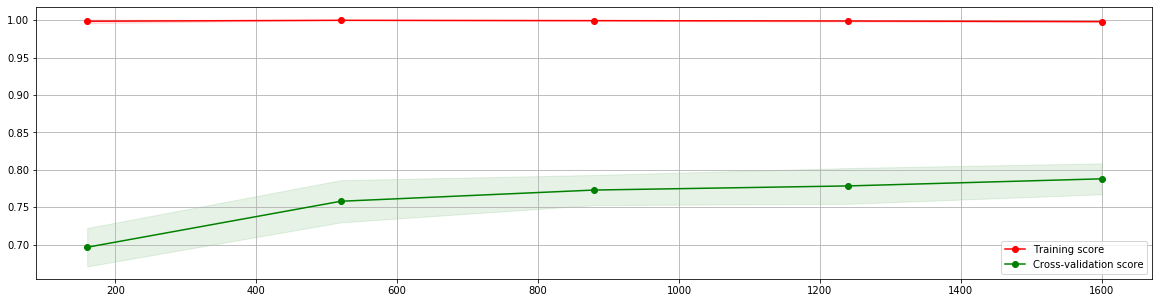

In [70]:
curve_plot(pipe, data_samples_cleared, y, 4)

## LogisticRegression

In [90]:
cls = LogisticRegression(C=60, random_state=0, solver='liblinear')
pipe = pipeline_imb(steps=[
    ('vectorizer', vectorizer),
    ("tfidf", TfidfTransformer()),
    ('sampling', RandomOverSampler(random_state=0)),
    ('cls', cls)
])

checking(pipe, data_samples_cleared, y, 10, n_jobs=-1, scoring='roc_auc', cv=8)

Fitting train ...
done in 0.487s.
Predicting validation ...
done in 0.178s.
AUC score : 0.8557
Cross-validation ...
roc_auc
(array([0.8702, 0.9035, 0.8669, 0.8649, 0.8802, 0.8881, 0.8831, 0.8803]), 0.8796, 0.0118)
done in 7.013s.


In [82]:
param_distributions = {'cls__C': uniform(loc=1, scale=100)}
search = RandomizedSearchCV(pipe,
                            param_distributions,
                            verbose=1,
                            n_jobs=4,
                            n_iter=50,
                            scoring='roc_auc',
                            random_state=0)
search.fit(data_samples_cleared, y)
print(search.best_score_.round(4), search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.7s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   54.6s finished


0.8766 {'cls__C': 61.276337607164386}


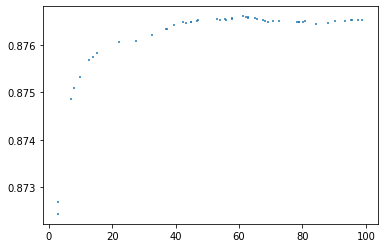

In [83]:
plt.scatter(search.cv_results_['param_cls__C'].data,
            search.cv_results_['mean_test_score'],
            s=2,
            marker="_")

In [85]:
[(x.mean().round(4), x.std().round(4), x.round(4))
 for x in [cross_val_score(pipe, data_samples_cleared, y, n_jobs=-1, cv = 8)]]

[(0.8095,
  0.0133,
  array([0.808, 0.828, 0.816, 0.796, 0.796, 0.792, 0.828, 0.812]))]

In [86]:
pipe.fit(X_train,y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       240
           1       0.83      0.88      0.85       420

    accuracy                           0.81       660
   macro avg       0.79      0.78      0.79       660
weighted avg       0.80      0.81      0.80       660



In [87]:
confusion_matrix(y_val, pipe.predict(X_val), labels = [0, 1])

array([[164,  76],
       [ 52, 368]])

In [88]:
errors = X_val[pipe.predict(X_val) != y_val.values]
len(errors)

128

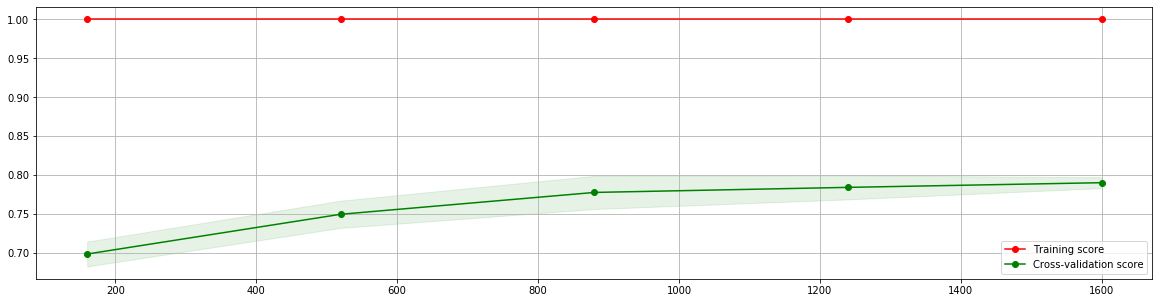

In [91]:
curve_plot(pipe, data_samples_cleared, y, 4)

## SVM

In [106]:
cls = SVC(kernel='sigmoid',
          random_state=0,
          class_weight='balanced',
          probability=True,
          C=3.0)
pipe = pipeline_imb(
    steps=[('vectorizer', vectorizer), (
        "tfidf",
        TfidfTransformer()), ('sampling',
                              RandomOverSampler(random_state=0)), ('cls',
                                                                   cls)])
checking(pipe, data_samples_cleared, y, 22, n_jobs=4, scoring='roc_auc', cv=8)

Fitting train ...
done in 3.939s.
Predicting validation ...
done in 0.336s.
AUC score : 0.8552
Cross-validation ...
roc_auc
(array([0.8839, 0.8972, 0.8663, 0.8695, 0.8782, 0.8806, 0.8761, 0.8828]), 0.8793, 0.0089)
done in 17.485s.


In [103]:
param_distributions = {'cls__C': uniform(loc=1, scale=100)}
search = RandomizedSearchCV(pipe,
                            param_distributions,
                            verbose=1,
                            n_jobs=4,
                            n_iter=20,
                            scoring='roc_auc',
                            random_state=0)
search.fit(data_samples_cleared, y)
print(search.best_score_.round(4), search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  8.3min finished


0.8745 {'cls__C': 2.878980043635514}


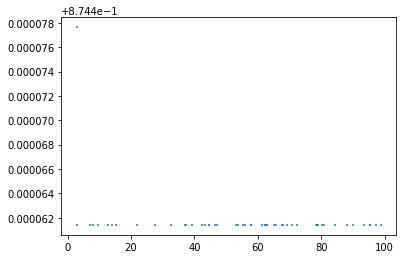

In [105]:
plt.scatter(search.cv_results_['param_cls__C'].data,
            search.cv_results_['mean_test_score'],
            s=2,
            marker="_")

In [107]:
[(x.mean().round(4), x.std().round(4), x.round(4))
 for x in [cross_val_score(pipe, data_samples_cleared, y, n_jobs=-1, cv = 8)]]

[(0.8135,
  0.0154,
  array([0.828, 0.84 , 0.8  , 0.796, 0.8  , 0.804, 0.812, 0.828]))]

In [108]:
pipe.fit(X_train,y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       240
           1       0.84      0.86      0.85       420

    accuracy                           0.81       660
   macro avg       0.79      0.79      0.79       660
weighted avg       0.81      0.81      0.81       660



In [109]:
confusion_matrix(y_val, pipe.predict(X_val), labels = [0, 1])

array([[171,  69],
       [ 58, 362]])

In [110]:
errors = X_val[pipe.predict(X_val) != y_val.values]
len(errors)

127

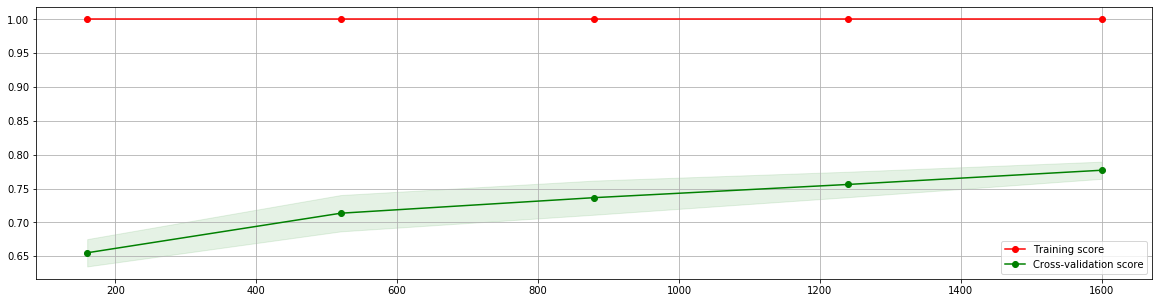

In [101]:
curve_plot(pipe, data_samples_cleared, y, 4)

# Model : Chars

In [204]:
# data transformer - vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(2, 7),
    min_df=1,
    analyzer='char'
)

In [205]:
# split data to train/validation sets
X_train, X_val, y_train, y_val = split_data(data_samples, y, r_seed)

# Classifiers

## NB

In [206]:
cls = ComplementNB()
pipe = pipeline_imb(
    steps=[
        ('vectorizer', vectorizer),
        ("tfidf", TfidfTransformer()),
        ('sampling', RandomOverSampler(random_state=0)),
        ('cls', cls)])
checking(pipe, data_samples, y, 10, n_jobs=4, scoring='roc_auc', cv=8)

Fitting train ...
done in 1.288s.
Predicting validation ...
done in 0.394s.
AUC score : 0.8549
Cross-validation ...
roc_auc
(array([0.8669, 0.9124, 0.8661, 0.8641, 0.869 , 0.8932, 0.8932, 0.8676]), 0.8791, 0.0169)
done in 7.571s.


In [207]:
[(x.mean().round(4), x.std().round(4), x.round(4))
 for x in [cross_val_score(pipe, data_samples, y, n_jobs=-1, cv = 8)]]

[(0.797,
  0.0198,
  array([0.78 , 0.832, 0.82 , 0.776, 0.784, 0.812, 0.784, 0.788]))]

In [208]:
pipe.fit(X_train,y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       240
           1       0.86      0.76      0.81       420

    accuracy                           0.77       660
   macro avg       0.75      0.77      0.76       660
weighted avg       0.78      0.77      0.77       660



In [209]:
confusion_matrix(y_val, pipe.predict(X_val), labels = [0, 1])

array([[186,  54],
       [ 99, 321]])

In [210]:
errors = X_val[pipe.predict(X_val) != y_val.values]
len(errors)

153

## Logistic Regression

In [211]:
cls = LogisticRegression(C=3, random_state=0, solver='liblinear')
pipe = pipeline_imb(
    steps=[
        ('vectorizer', vectorizer),
        ("tfidf", TfidfTransformer()),
        ('sampling', RandomOverSampler(random_state=0)),
        ('cls', cls)])
checking(pipe, data_samples, y, 10, n_jobs=4, scoring='roc_auc', cv=8)

Fitting train ...
done in 1.442s.
Predicting validation ...
done in 0.421s.
AUC score : 0.8506
Cross-validation ...
roc_auc
(array([0.8705, 0.9126, 0.8658, 0.867 , 0.8733, 0.9005, 0.8855, 0.8792]), 0.8818, 0.0158)
done in 10.113s.


In [216]:
[(x.mean().round(4), x.std().round(4), x.round(4))
 for x in [cross_val_score(pipe, data_samples, y, n_jobs=4, cv = 5)]]

[(0.795, 0.0213, array([0.795 , 0.8225, 0.805 , 0.7575, 0.795 ]))]

In [213]:
pipe.fit(X_train,y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       240
           1       0.81      0.87      0.84       420

    accuracy                           0.79       660
   macro avg       0.77      0.76      0.76       660
weighted avg       0.78      0.79      0.78       660



In [214]:
confusion_matrix(y_val, pipe.predict(X_val), labels = [0, 1])

array([[154,  86],
       [ 55, 365]])

In [215]:
errors = X_val[pipe.predict(X_val) != y_val.values]
len(errors)

141

## SVM

In [201]:
cls = SVC(kernel='rbf',
          random_state=0,
          class_weight='balanced',
          probability=True,
          C=3.0)
pipe = pipeline_imb(
    steps=[('vectorizer', vectorizer), (
        "tfidf",
        TfidfTransformer()), ('sampling',
                              RandomOverSampler(random_state=0)), ('cls',
                                                                   cls)])
# checking(pipe, data_samples_cleared, y, 22, n_jobs=4, scoring='roc_auc', cv=8)

In [203]:
[(x.mean().round(4), x.std().round(4), x.round(4))
 for x in [cross_val_score(pipe, data_samples, y, n_jobs=4, cv = 8)]]

KeyboardInterrupt: 

In [197]:
pipe.fit(X_train,y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.71      0.66      0.69       240
           1       0.81      0.85      0.83       420

    accuracy                           0.78       660
   macro avg       0.76      0.76      0.76       660
weighted avg       0.78      0.78      0.78       660



In [198]:
confusion_matrix(y_val, pipe.predict(X_val), labels = [0, 1])

array([[159,  81],
       [ 64, 356]])

In [199]:
errors = X_val[pipe.predict(X_val) != y_val.values]
len(errors)

145